With SMOTE

In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load your dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/models/dataset_dementia (1) (1) (4).csv")

# Drop rows with missing target
df = df.dropna(subset=["dementia"])

X = df.drop("dementia", axis=1).copy()
y = df["dementia"].values.astype(int)

# Define feature groups
num_features = ["age", "educationyears", "EF", "PS", "Global"]
# We'll label-encode 'smoking' (treated as ordinal-like), OHE the rest
cat_ohe_features = ["gender", "diabetes", "hypertension", "hypercholesterolemia"]
cat_label_features = ["smoking"]  # "necessary" feature to label-encode

# Keep only available columns (in case of dataset variations)
num_features = [c for c in num_features if c in X.columns]
cat_ohe_features = [c for c in cat_ohe_features if c in X.columns]
cat_label_features = [c for c in cat_label_features if c in X.columns]

# ======================================
# STEP 2: Helper Functions (DL builders)
# ======================================
def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 3: Stratified CV for ML models
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

# Storage
results_ml = []
oof_preds = {name: np.zeros(len(y), dtype=int) for name in ml_models.keys()}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation inside fold ===
    # Numeric: mean imputation + scaling
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
    X_test_num  = num_imputer.transform(X_test[num_features]) if num_features else np.empty((len(X_test),0))
    if num_features:
        X_train_num = scaler.fit_transform(X_train_num)
        X_test_num  = scaler.transform(X_test_num)

    # Categorical: mode imputation
    # One-hot with drop='first' for nominal features
    if cat_ohe_features:
        cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
        X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
        X_test_ohe_imp  = X_test[cat_ohe_features].fillna(cat_mode_ohe)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
        X_test_ohe  = ohe.transform(X_test_ohe_imp)
    else:
        X_train_ohe = np.empty((len(X_train),0))
        X_test_ohe  = np.empty((len(X_test),0))

    # Label-encoding (ordinal) for selected feature(s)
    if cat_label_features:
        cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
        X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
        X_test_lbl_imp  = X_test[cat_label_features].fillna(cat_mode_lbl)
        # Use OrdinalEncoder for feature columns
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
        X_test_lbl  = ord_enc.transform(X_test_lbl_imp)
    else:
        X_train_lbl = np.empty((len(X_train),0))
        X_test_lbl  = np.empty((len(X_test),0))

    # Combine all processed blocks
    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe,  X_test_lbl])

    # === Apply SMOTE to training only ===
    sm = SMOTE(random_state=42)
    X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

    # === Train and evaluate ML models ===
    for name, model in ml_models.items():
        model.fit(X_train_f_bal, y_train_bal)
        y_pred = model.predict(X_test_f)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results_ml.append([name, fold, acc, prec, rec, f1])
        oof_preds[name][test_idx] = y_pred

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])

# Print ML summary (mean over folds)
print("=== ML Models Performance (mean over 5 folds) ===")
for model, grp in results_ml.groupby("Model"):
    print(f"{model}: "
          f"Acc={grp['Accuracy'].mean():.3f}, "
          f"Prec={grp['Precision'].mean():.3f}, "
          f"Rec={grp['Recall'].mean():.3f}, "
          f"F1={grp['F1'].mean():.3f}")

# ======================================
# STEP 4: Stratified CV for DL models
# ======================================
results_dl = []
oof_preds_dl = {"HNN": np.zeros(len(y), dtype=int), "CNN+Transformer": np.zeros(len(y), dtype=int)}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation & scaling (same as ML for consistency) ===
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
    X_test_num  = num_imputer.transform(X_test[num_features]) if num_features else np.empty((len(X_test),0))
    if num_features:
        X_train_num = scaler.fit_transform(X_train_num)
        X_test_num  = scaler.transform(X_test_num)

    # OHE (drop='first') for nominal cats
    if cat_ohe_features:
        cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
        X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
        X_test_ohe_imp  = X_test[cat_ohe_features].fillna(cat_mode_ohe)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
        X_test_ohe  = ohe.transform(X_test_ohe_imp)
    else:
        X_train_ohe = np.empty((len(X_train),0))
        X_test_ohe  = np.empty((len(X_test),0))

    # Label-encoded cats (ordinal) for selected feature(s)
    if cat_label_features:
        cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
        X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
        X_test_lbl_imp  = X_test[cat_label_features].fillna(cat_mode_lbl)
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
        X_test_lbl  = ord_enc.transform(X_test_lbl_imp)
    else:
        X_train_lbl = np.empty((len(X_train),0))
        X_test_lbl  = np.empty((len(X_test),0))

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe,  X_test_lbl])

    # SMOTE on training only
    sm = SMOTE(random_state=42)
    X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

    y_train_np, y_test_np = np.array(y_train_bal), np.array(y_test)

    # === HNN ===
    hnn = build_hnn(X_train_f_bal.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f_bal, y_train_np, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = hnn.predict(X_test_f, verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results_dl.append(["HNN", fold, acc, prec, rec, f1])
    oof_preds_dl["HNN"][test_idx] = y_pred

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f_bal.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f_bal,-1), y_train_np,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_proba = cnn_tr.predict(np.expand_dims(X_test_f,-1), verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results_dl.append(["CNN+Transformer", fold, acc, prec, rec, f1])
    oof_preds_dl["CNN+Transformer"][test_idx] = y_pred

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])

# Print DL summary (mean over folds)
print("\n=== DL Models Performance (mean over 5 folds) ===")
for model, grp in results_dl.groupby("Model"):
    print(f"{model}: "
          f"Acc={grp['Accuracy'].mean():.3f}, "
          f"Prec={grp['Precision'].mean():.3f}, "
          f"Rec={grp['Recall'].mean():.3f}, "
          f"F1={grp['F1'].mean():.3f}")

# Optional: full per-fold tables
print("\n--- Per-fold ML results ---")
print(results_ml.sort_values(["Model","Fold"]).to_string(index=False))

print("\n--- Per-fold DL results ---")
print(results_dl.sort_values(["Model","Fold"]).to_string(index=False))


=== ML Models Performance (mean over 5 folds) ===
GaussianNB: Acc=0.737, Prec=0.109, Rec=0.670, F1=0.188
KNN: Acc=0.821, Prec=0.117, Rec=0.438, F1=0.184
MLP: Acc=0.924, Prec=0.214, Rec=0.219, F1=0.209
RandomForest: Acc=0.931, Prec=0.204, Rec=0.171, F1=0.181
SVM: Acc=0.778, Prec=0.104, Rec=0.512, F1=0.173

=== DL Models Performance (mean over 5 folds) ===
CNN+Transformer: Acc=0.854, Prec=0.123, Rec=0.315, F1=0.175
HNN: Acc=0.890, Prec=0.155, Rec=0.307, F1=0.204

--- Per-fold ML results ---
       Model  Fold  Accuracy  Precision   Recall       F1
  GaussianNB     0  0.759669   0.126316 0.750000 0.216216
  GaussianNB     1  0.723757   0.104762 0.647059 0.180328
  GaussianNB     2  0.740331   0.126214 0.764706 0.216667
  GaussianNB     3  0.722992   0.096154 0.625000 0.166667
  GaussianNB     4  0.739612   0.093750 0.562500 0.160714
         KNN     0  0.787293   0.082192 0.375000 0.134831
         KNN     1  0.801105   0.101449 0.411765 0.162791
         KNN     2  0.825967   0.140625 0.

In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load your dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/models/dataset_dementia (1) (1) (4).csv")

# Drop rows with missing target
df = df.dropna(subset=["dementia"])

X = df.drop("dementia", axis=1).copy()
y = df["dementia"].values.astype(int)

# Define feature groups
num_features = ["age", "educationyears", "EF", "PS", "Global"]
# We'll label-encode 'smoking' (treated as ordinal-like), OHE the rest
cat_ohe_features = ["gender", "diabetes", "hypertension", "hypercholesterolemia"]
cat_label_features = ["smoking"]  # "necessary" feature to label-encode

# Keep only available columns (in case of dataset variations)
num_features = [c for c in num_features if c in X.columns]
cat_ohe_features = [c for c in cat_ohe_features if c in X.columns]
cat_label_features = [c for c in cat_label_features if c in X.columns]

# ======================================
# STEP 2: Helper Functions (DL builders)
# ======================================
def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 3: Stratified CV for ML models
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

# Storage
results_ml = []
oof_preds = {name: np.zeros(len(y), dtype=int) for name in ml_models.keys()}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation inside fold ===
    # Numeric: mean imputation + scaling
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
    X_test_num  = num_imputer.transform(X_test[num_features]) if num_features else np.empty((len(X_test),0))
    if num_features:
        X_train_num = scaler.fit_transform(X_train_num)
        X_test_num  = scaler.transform(X_test_num)

    # Categorical: mode imputation
    # One-hot with drop='first' for nominal features
    if cat_ohe_features:
        cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
        X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
        X_test_ohe_imp  = X_test[cat_ohe_features].fillna(cat_mode_ohe)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
        X_test_ohe  = ohe.transform(X_test_ohe_imp)
    else:
        X_train_ohe = np.empty((len(X_train),0))
        X_test_ohe  = np.empty((len(X_test),0))

    # Label-encoding (ordinal) for selected feature(s)
    if cat_label_features:
        cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
        X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
        X_test_lbl_imp  = X_test[cat_label_features].fillna(cat_mode_lbl)
        # Use OrdinalEncoder for feature columns
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
        X_test_lbl  = ord_enc.transform(X_test_lbl_imp)
    else:
        X_train_lbl = np.empty((len(X_train),0))
        X_test_lbl  = np.empty((len(X_test),0))

    # Combine all processed blocks
    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe,  X_test_lbl])

    # === Apply SMOTE to training only ===
    sm = SMOTE(random_state=42)
    X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

    # === Train and evaluate ML models ===
    for name, model in ml_models.items():
        model.fit(X_train_f_bal, y_train_bal)
        y_pred = model.predict(X_test_f)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results_ml.append([name, fold, acc, prec, rec, f1])
        oof_preds[name][test_idx] = y_pred

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])

# Print ML summary (mean over folds)
print("=== ML Models Performance (mean over 5 folds) ===")
for model, grp in results_ml.groupby("Model"):
    print(f"{model}: "
          f"Acc={grp['Accuracy'].mean():.3f}, "
          f"Prec={grp['Precision'].mean():.3f}, "
          f"Rec={grp['Recall'].mean():.3f}, "
          f"F1={grp['F1'].mean():.3f}")

# ======================================
# STEP 4: Stratified CV for DL models
# ======================================
results_dl = []
oof_preds_dl = {"HNN": np.zeros(len(y), dtype=int), "CNN+Transformer": np.zeros(len(y), dtype=int)}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation & scaling (same as ML for consistency) ===
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
    X_test_num  = num_imputer.transform(X_test[num_features]) if num_features else np.empty((len(X_test),0))
    if num_features:
        X_train_num = scaler.fit_transform(X_train_num)
        X_test_num  = scaler.transform(X_test_num)

    # OHE (drop='first') for nominal cats
    if cat_ohe_features:
        cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
        X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
        X_test_ohe_imp  = X_test[cat_ohe_features].fillna(cat_mode_ohe)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
        X_test_ohe  = ohe.transform(X_test_ohe_imp)
    else:
        X_train_ohe = np.empty((len(X_train),0))
        X_test_ohe  = np.empty((len(X_test),0))

    # Label-encoded cats (ordinal) for selected feature(s)
    if cat_label_features:
        cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
        X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
        X_test_lbl_imp  = X_test[cat_label_features].fillna(cat_mode_lbl)
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
        X_test_lbl  = ord_enc.transform(X_test_lbl_imp)
    else:
        X_train_lbl = np.empty((len(X_train),0))
        X_test_lbl  = np.empty((len(X_test),0))

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe,  X_test_lbl])

    # SMOTE on training only
    sm = SMOTE(random_state=42)
    X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

    y_train_np, y_test_np = np.array(y_train_bal), np.array(y_test)

    # === HNN ===
    hnn = build_hnn(X_train_f_bal.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f_bal, y_train_np, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = hnn.predict(X_test_f, verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results_dl.append(["HNN", fold, acc, prec, rec, f1])
    oof_preds_dl["HNN"][test_idx] = y_pred

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f_bal.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f_bal,-1), y_train_np,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_proba = cnn_tr.predict(np.expand_dims(X_test_f,-1), verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results_dl.append(["CNN+Transformer", fold, acc, prec, rec, f1])
    oof_preds_dl["CNN+Transformer"][test_idx] = y_pred

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])

# Print DL summary (mean over folds)
print("\n=== DL Models Performance (mean over 5 folds) ===")
for model, grp in results_dl.groupby("Model"):
    print(f"{model}: "
          f"Acc={grp['Accuracy'].mean():.3f}, "
          f"Prec={grp['Precision'].mean():.3f}, "
          f"Rec={grp['Recall'].mean():.3f}, "
          f"F1={grp['F1'].mean():.3f}")

# Optional: full per-fold tables
print("\n--- Per-fold ML results ---")
print(results_ml.sort_values(["Model","Fold"]).to_string(index=False))

print("\n--- Per-fold DL results ---")
print(results_dl.sort_values(["Model","Fold"]).to_string(index=False))


=== ML Models Performance (mean over 5 folds) ===
GaussianNB: Acc=0.737, Prec=0.109, Rec=0.670, F1=0.188
KNN: Acc=0.821, Prec=0.117, Rec=0.438, F1=0.184
MLP: Acc=0.924, Prec=0.214, Rec=0.219, F1=0.209
RandomForest: Acc=0.931, Prec=0.204, Rec=0.171, F1=0.181
SVM: Acc=0.778, Prec=0.104, Rec=0.512, F1=0.173

=== DL Models Performance (mean over 5 folds) ===
CNN+Transformer: Acc=0.848, Prec=0.112, Rec=0.328, F1=0.166
HNN: Acc=0.892, Prec=0.132, Rec=0.245, F1=0.171

--- Per-fold ML results ---
       Model  Fold  Accuracy  Precision   Recall       F1
  GaussianNB     0  0.759669   0.126316 0.750000 0.216216
  GaussianNB     1  0.723757   0.104762 0.647059 0.180328
  GaussianNB     2  0.740331   0.126214 0.764706 0.216667
  GaussianNB     3  0.722992   0.096154 0.625000 0.166667
  GaussianNB     4  0.739612   0.093750 0.562500 0.160714
         KNN     0  0.787293   0.082192 0.375000 0.134831
         KNN     1  0.801105   0.101449 0.411765 0.162791
         KNN     2  0.825967   0.140625 0.

In [ ]:
from collections import Counter

# Storage for data counts
smote_counts = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # Preprocessing (numeric, categorical, same as before)
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
    if num_features:
        X_train_num = scaler.fit_transform(X_train_num)

    if cat_ohe_features:
        cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
        X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
    else:
        X_train_ohe = np.empty((len(X_train),0))

    if cat_label_features:
        cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
        X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
    else:
        X_train_lbl = np.empty((len(X_train),0))

    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])

    # === Before SMOTE counts ===
    before_counts = Counter(y_train)

    # Apply SMOTE
    sm = SMOTE(random_state=42)
    X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

    # === After SMOTE counts ===
    after_counts = Counter(y_train_bal)

    # Save results
    smote_counts.append({
        "Fold": fold+1,
        "Before": dict(before_counts),
        "After": dict(after_counts),
        "Total_Before": len(y_train),
        "Total_After": len(y_train_bal)
    })

# Convert to DataFrame for readability
smote_df = pd.DataFrame(smote_counts)
print("\n=== Data counts before and after SMOTE per fold ===")
print(smote_df.to_string(index=False))



=== Data counts before and after SMOTE per fold ===
 Fold           Before              After  Total_Before  Total_After
    1 {0: 1380, 1: 66} {0: 1380, 1: 1380}          1446         2760
    2 {0: 1381, 1: 65} {0: 1381, 1: 1381}          1446         2762
    3 {0: 1381, 1: 65} {0: 1381, 1: 1381}          1446         2762
    4 {0: 1381, 1: 66} {0: 1381, 1: 1381}          1447         2762
    5 {0: 1381, 1: 66} {0: 1381, 1: 1381}          1447         2762


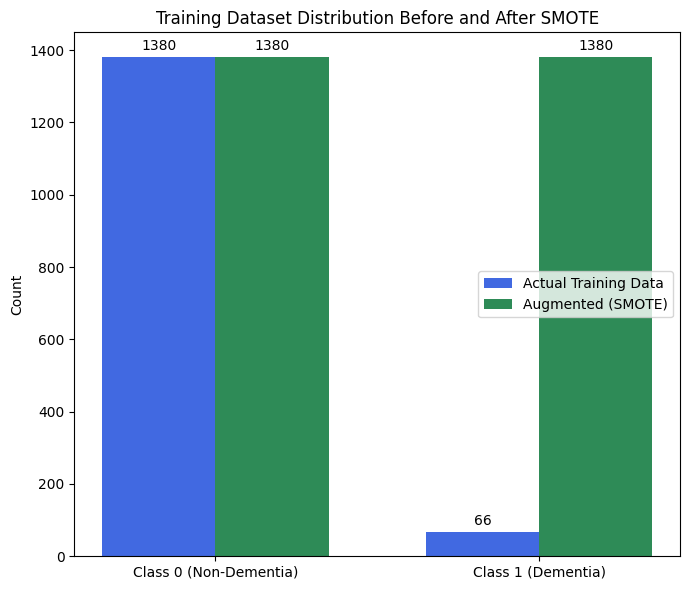

In [ ]:
import matplotlib.pyplot as plt

# Use first fold training set to show distribution
train_idx, test_idx = next(skf.split(X, y))
X_train, y_train = X.iloc[train_idx], y[train_idx]

# Before SMOTE counts
before_counts = pd.Series(y_train).value_counts().sort_index()

# Apply preprocessing + SMOTE just like in training pipeline
num_imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
if num_features:
    X_train_num = scaler.fit_transform(X_train_num)

if cat_ohe_features:
    cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
    X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
    ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
else:
    X_train_ohe = np.empty((len(X_train),0))

if cat_label_features:
    cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
    X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
    ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
else:
    X_train_lbl = np.empty((len(X_train),0))

X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])

sm = SMOTE(random_state=42)
X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

after_counts = pd.Series(y_train_bal).value_counts().sort_index()

# ===== Plot =====
labels = ["Class 0 (Non-Dementia)", "Class 1 (Dementia)"]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(7,6))
rects1 = ax.bar(x - width/2, before_counts, width, label="Actual Training Data", color="royalblue")
rects2 = ax.bar(x + width/2, after_counts, width, label="Augmented (SMOTE)", color="seagreen")

ax.set_ylabel("Count")
ax.set_title("Training Dataset Distribution Before and After SMOTE")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotate bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha="center", va="bottom")

plt.tight_layout()
plt.show()


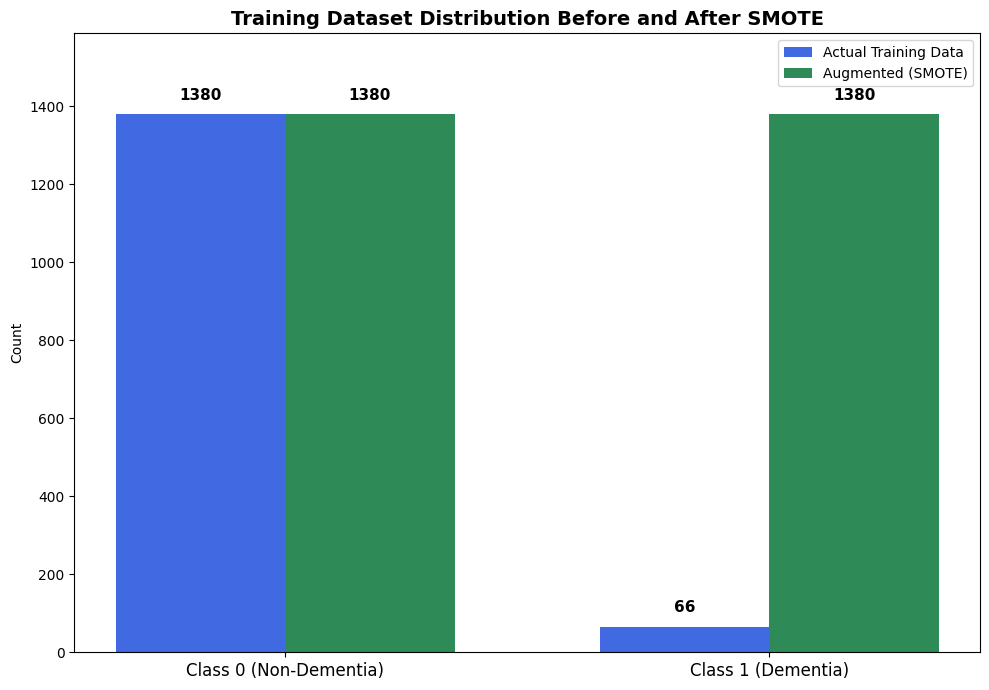

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Use first fold training set to show distribution
train_idx, test_idx = next(skf.split(X, y))
X_train, y_train = X.iloc[train_idx], y[train_idx]

# Before SMOTE counts
before_counts = pd.Series(y_train).value_counts().sort_index()

# Apply preprocessing + SMOTE just like in training pipeline
num_imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
if num_features:
    X_train_num = scaler.fit_transform(X_train_num)

if cat_ohe_features:
    cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
    X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
    ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
else:
    X_train_ohe = np.empty((len(X_train),0))

if cat_label_features:
    cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
    X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
    ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
else:
    X_train_lbl = np.empty((len(X_train),0))

X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])

sm = SMOTE(random_state=42)
X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

after_counts = pd.Series(y_train_bal).value_counts().sort_index()

# ===== Plot =====
labels = ["Class 0 (Non-Dementia)", "Class 1 (Dementia)"]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,7))  # bigger figure size
rects1 = ax.bar(x - width/2, before_counts, width, label="Actual Training Data", color="royalblue")
rects2 = ax.bar(x + width/2, after_counts, width, label="Augmented (SMOTE)", color="seagreen")

ax.set_ylabel("Count")
ax.set_title("Training Dataset Distribution Before and After SMOTE", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend()

# Set Y-axis limit so annotations fit well
max_count = max(before_counts.max(), after_counts.max())
ax.set_ylim(0, max_count + int(0.15*max_count))  # add 15% headroom

# Annotate bars ABOVE the bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,8),  # move text above
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=11, fontweight="bold")

plt.tight_layout()
plt.show()


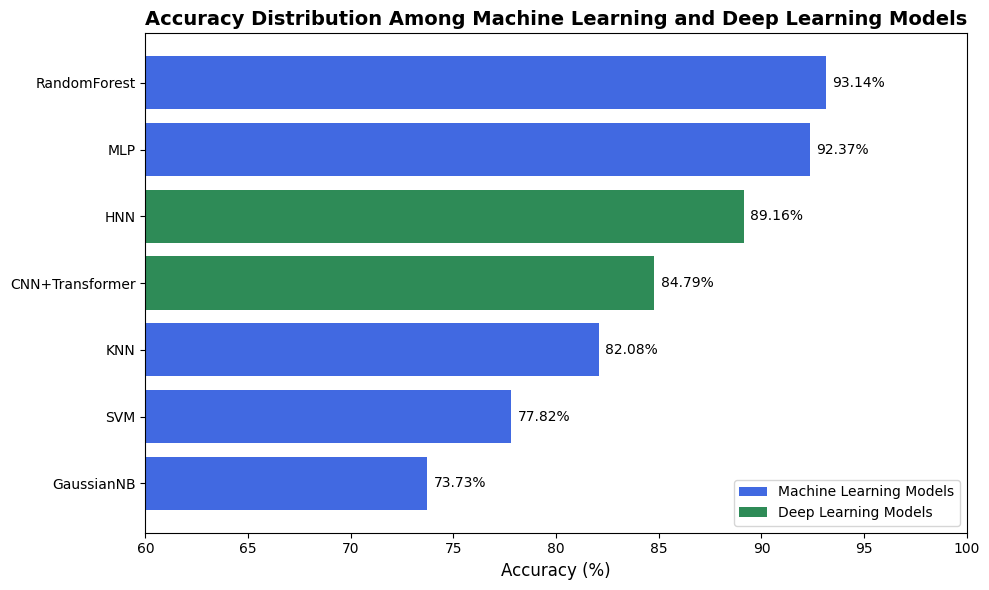

In [ ]:
import matplotlib.pyplot as plt

# === Aggregate mean accuracy across folds ===
ml_summary = results_ml.groupby("Model")["Accuracy"].mean()
dl_summary = results_dl.groupby("Model")["Accuracy"].mean()

# Combine results
all_results = pd.concat([ml_summary, dl_summary])
model_types = {m:"ML" for m in ml_summary.index}
model_types.update({m:"DL" for m in dl_summary.index})

# Sort by accuracy
all_results = all_results.sort_values(ascending=False)

# === Plot ===
plt.figure(figsize=(10,6))
colors = ["royalblue" if model_types[m]=="ML" else "seagreen" for m in all_results.index]
bars = plt.barh(all_results.index, all_results.values*100, color=colors)

plt.xlabel("Accuracy (%)", fontsize=12)
plt.title("Accuracy Distribution Among Machine Learning and Deep Learning Models", fontsize=14, fontweight="bold")

# Add values to bars
for bar, value in zip(bars, all_results.values*100):
    plt.text(bar.get_width()+0.3, bar.get_y() + bar.get_height()/2,
             f"{value:.2f}%", va="center", fontsize=10)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor="royalblue", label="Machine Learning Models"),
                   Patch(facecolor="seagreen", label="Deep Learning Models")]
plt.legend(handles=legend_elements, loc="lower right")

plt.xlim(60, 100)  # match your figure’s range
plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()


Without SMOTE

In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load your dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/models/dataset_dementia (1) (1) (4).csv")

# Drop rows with missing target
df = df.dropna(subset=["dementia"])

X = df.drop("dementia", axis=1).copy()
y = df["dementia"].values.astype(int)

# Define feature groups
num_features = ["age", "educationyears", "EF", "PS", "Global"]
cat_ohe_features = ["gender", "diabetes", "hypertension", "hypercholesterolemia"]
cat_label_features = ["smoking"]

# Keep only available columns
num_features = [c for c in num_features if c in X.columns]
cat_ohe_features = [c for c in cat_ohe_features if c in X.columns]
cat_label_features = [c for c in cat_label_features if c in X.columns]

# ======================================
# STEP 2: Helper Functions (DL builders)
# ======================================
def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 3: Stratified CV for ML models
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []
oof_preds = {name: np.zeros(len(y), dtype=int) for name in ml_models.keys()}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation inside fold ===
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
    X_test_num  = num_imputer.transform(X_test[num_features]) if num_features else np.empty((len(X_test),0))
    if num_features:
        X_train_num = scaler.fit_transform(X_train_num)
        X_test_num  = scaler.transform(X_test_num)

    # Categorical: mode imputation
    if cat_ohe_features:
        cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
        X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
        X_test_ohe_imp  = X_test[cat_ohe_features].fillna(cat_mode_ohe)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
        X_test_ohe  = ohe.transform(X_test_ohe_imp)
    else:
        X_train_ohe = np.empty((len(X_train),0))
        X_test_ohe  = np.empty((len(X_test),0))

    if cat_label_features:
        cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
        X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
        X_test_lbl_imp  = X_test[cat_label_features].fillna(cat_mode_lbl)
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
        X_test_lbl  = ord_enc.transform(X_test_lbl_imp)
    else:
        X_train_lbl = np.empty((len(X_train),0))
        X_test_lbl  = np.empty((len(X_test),0))

    # Combine all processed blocks
    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe,  X_test_lbl])

    # === Train and evaluate ML models ===
    for name, model in ml_models.items():
        model.fit(X_train_f, y_train)
        y_pred = model.predict(X_test_f)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results_ml.append([name, fold, acc, prec, rec, f1])
        oof_preds[name][test_idx] = y_pred

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])

print("=== ML Models Performance (mean over 5 folds) ===")
for model, grp in results_ml.groupby("Model"):
    print(f"{model}: "
          f"Acc={grp['Accuracy'].mean():.3f}, "
          f"Prec={grp['Precision'].mean():.3f}, "
          f"Rec={grp['Recall'].mean():.3f}, "
          f"F1={grp['F1'].mean():.3f}")

# ======================================
# STEP 4: Stratified CV for DL models
# ======================================
results_dl = []
oof_preds_dl = {"HNN": np.zeros(len(y), dtype=int), "CNN+Transformer": np.zeros(len(y), dtype=int)}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation & scaling (same as ML) ===
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
    X_test_num  = num_imputer.transform(X_test[num_features]) if num_features else np.empty((len(X_test),0))
    if num_features:
        X_train_num = scaler.fit_transform(X_train_num)
        X_test_num  = scaler.transform(X_test_num)

    if cat_ohe_features:
        cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
        X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
        X_test_ohe_imp  = X_test[cat_ohe_features].fillna(cat_mode_ohe)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
        X_test_ohe  = ohe.transform(X_test_ohe_imp)
    else:
        X_train_ohe = np.empty((len(X_train),0))
        X_test_ohe  = np.empty((len(X_test),0))

    if cat_label_features:
        cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
        X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
        X_test_lbl_imp  = X_test[cat_label_features].fillna(cat_mode_lbl)
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
        X_test_lbl  = ord_enc.transform(X_test_lbl_imp)
    else:
        X_train_lbl = np.empty((len(X_train),0))
        X_test_lbl  = np.empty((len(X_test),0))

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe,  X_test_lbl])

    y_train_np, y_test_np = np.array(y_train), np.array(y_test)

    # === HNN ===
    hnn = build_hnn(X_train_f.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f, y_train_np, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = hnn.predict(X_test_f, verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results_dl.append(["HNN", fold, acc, prec, rec, f1])
    oof_preds_dl["HNN"][test_idx] = y_pred

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f,-1), y_train_np,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_proba = cnn_tr.predict(np.expand_dims(X_test_f,-1), verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results_dl.append(["CNN+Transformer", fold, acc, prec, rec, f1])
    oof_preds_dl["CNN+Transformer"][test_idx] = y_pred

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])

print("\n=== DL Models Performance (mean over 5 folds) ===")
for model, grp in results_dl.groupby("Model"):
    print(f"{model}: "
          f"Acc={grp['Accuracy'].mean():.3f}, "
          f"Prec={grp['Precision'].mean():.3f}, "
          f"Rec={grp['Recall'].mean():.3f}, "
          f"F1={grp['F1'].mean():.3f}")

print("\n--- Per-fold ML results ---")
print(results_ml.sort_values(["Model","Fold"]).to_string(index=False))

print("\n--- Per-fold DL results ---")
print(results_dl.sort_values(["Model","Fold"]).to_string(index=False))


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


=== ML Models Performance (mean over 5 folds) ===
GaussianNB: Acc=0.902, Prec=0.193, Rec=0.366, F1=0.251
KNN: Acc=0.956, Prec=0.667, Rec=0.073, F1=0.128
MLP: Acc=0.936, Prec=0.195, Rec=0.146, F1=0.166
RandomForest: Acc=0.956, Prec=0.550, Rec=0.085, F1=0.143
SVM: Acc=0.955, Prec=0.100, Rec=0.012, F1=0.021

=== DL Models Performance (mean over 5 folds) ===
CNN+Transformer: Acc=0.955, Prec=0.000, Rec=0.000, F1=0.000
HNN: Acc=0.955, Prec=0.000, Rec=0.000, F1=0.000

--- Per-fold ML results ---
       Model  Fold  Accuracy  Precision   Recall       F1
  GaussianNB     0  0.919890   0.259259 0.437500 0.325581
  GaussianNB     1  0.908840   0.166667 0.235294 0.195122
  GaussianNB     2  0.903315   0.235294 0.470588 0.313725
  GaussianNB     3  0.883657   0.175000 0.437500 0.250000
  GaussianNB     4  0.891967   0.129032 0.250000 0.170213
         KNN     0  0.950276   0.000000 0.000000 0.000000
         KNN     1  0.955801   1.000000 0.058824 0.111111
         KNN     2  0.955801   0.666667 0.

With Gaussian augmentation

In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load your dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/models/dataset_dementia (1) (1) (4).csv")

# Drop rows with missing target
df = df.dropna(subset=["dementia"])

X = df.drop("dementia", axis=1).copy()
y = df["dementia"].values.astype(int)

# Define feature groups
num_features = ["age", "educationyears", "EF", "PS", "Global"]
cat_ohe_features = ["gender", "diabetes", "hypertension", "hypercholesterolemia"]
cat_label_features = ["smoking"]

# Keep only available columns
num_features = [c for c in num_features if c in X.columns]
cat_ohe_features = [c for c in cat_ohe_features if c in X.columns]
cat_label_features = [c for c in cat_label_features if c in X.columns]

# ======================================
# STEP 2: Helper Functions (DL builders)
# ======================================
def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 3: Stratified CV for ML models
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []
oof_preds = {name: np.zeros(len(y), dtype=int) for name in ml_models.keys()}

# Gaussian augmentation helper
def gaussian_augment(X, y, noise_std=0.01, factor=1.0):
    """Augments minority class with Gaussian noise"""
    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    X_aug, y_aug = [X], [y]
    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        n_needed = int((max_count - counts[cls]) * factor)
        if n_needed > 0:
            samples = X[cls_idx]
            noise = np.random.normal(0, noise_std, size=(n_needed, X.shape[1]))
            synthetic = samples[np.random.choice(len(samples), n_needed, replace=True)] + noise
            X_aug.append(synthetic)
            y_aug.append(np.full(n_needed, cls))
    return np.vstack(X_aug), np.hstack(y_aug)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation inside fold ===
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
    X_test_num  = num_imputer.transform(X_test[num_features]) if num_features else np.empty((len(X_test),0))
    if num_features:
        X_train_num = scaler.fit_transform(X_train_num)
        X_test_num  = scaler.transform(X_test_num)

    if cat_ohe_features:
        cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
        X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
        X_test_ohe_imp  = X_test[cat_ohe_features].fillna(cat_mode_ohe)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
        X_test_ohe  = ohe.transform(X_test_ohe_imp)
    else:
        X_train_ohe = np.empty((len(X_train),0))
        X_test_ohe  = np.empty((len(X_test),0))

    if cat_label_features:
        cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
        X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
        X_test_lbl_imp  = X_test[cat_label_features].fillna(cat_mode_lbl)
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
        X_test_lbl  = ord_enc.transform(X_test_lbl_imp)
    else:
        X_train_lbl = np.empty((len(X_train),0))
        X_test_lbl  = np.empty((len(X_test),0))

    # Combine features
    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe,  X_test_lbl])

    # === Gaussian augmentation instead of SMOTE ===
    X_train_f_bal, y_train_bal = gaussian_augment(X_train_f, y_train, noise_std=0.05, factor=1.0)

    # Train ML models
    for name, model in ml_models.items():
        model.fit(X_train_f_bal, y_train_bal)
        y_pred = model.predict(X_test_f)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results_ml.append([name, fold, acc, prec, rec, f1])
        oof_preds[name][test_idx] = y_pred

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])

print("=== ML Models Performance (mean over 5 folds) ===")
for model, grp in results_ml.groupby("Model"):
    print(f"{model}: "
          f"Acc={grp['Accuracy'].mean():.3f}, "
          f"Prec={grp['Precision'].mean():.3f}, "
          f"Rec={grp['Recall'].mean():.3f}, "
          f"F1={grp['F1'].mean():.3f}")

# ======================================
# STEP 4: Stratified CV for DL models
# ======================================
results_dl = []
oof_preds_dl = {"HNN": np.zeros(len(y), dtype=int), "CNN+Transformer": np.zeros(len(y), dtype=int)}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation & scaling (same as ML) ===
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
    X_test_num  = num_imputer.transform(X_test[num_features]) if num_features else np.empty((len(X_test),0))
    if num_features:
        X_train_num = scaler.fit_transform(X_train_num)
        X_test_num  = scaler.transform(X_test_num)

    if cat_ohe_features:
        cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
        X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
        X_test_ohe_imp  = X_test[cat_ohe_features].fillna(cat_mode_ohe)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
        X_test_ohe  = ohe.transform(X_test_ohe_imp)
    else:
        X_train_ohe = np.empty((len(X_train),0))
        X_test_ohe  = np.empty((len(X_test),0))

    if cat_label_features:
        cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
        X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
        X_test_lbl_imp  = X_test[cat_label_features].fillna(cat_mode_lbl)
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
        X_test_lbl  = ord_enc.transform(X_test_lbl_imp)
    else:
        X_train_lbl = np.empty((len(X_train),0))
        X_test_lbl  = np.empty((len(X_test),0))

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe,  X_test_lbl])

    # === Gaussian augmentation for DL ===
    X_train_f_bal, y_train_bal = gaussian_augment(X_train_f, y_train, noise_std=0.05, factor=1.0)

    y_train_np, y_test_np = np.array(y_train_bal), np.array(y_test)

    # === HNN ===
    hnn = build_hnn(X_train_f_bal.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f_bal, y_train_np, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = hnn.predict(X_test_f, verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)
    results_dl.append(["HNN", fold,
                       accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])
    oof_preds_dl["HNN"][test_idx] = y_pred

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f_bal.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f_bal,-1), y_train_np,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_proba = cnn_tr.predict(np.expand_dims(X_test_f,-1), verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)
    results_dl.append(["CNN+Transformer", fold,
                       accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])
    oof_preds_dl["CNN+Transformer"][test_idx] = y_pred

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])

print("\n=== DL Models Performance (mean over 5 folds) ===")
for model, grp in results_dl.groupby("Model"):
    print(f"{model}: "
          f"Acc={grp['Accuracy'].mean():.3f}, "
          f"Prec={grp['Precision'].mean():.3f}, "
          f"Rec={grp['Recall'].mean():.3f}, "
          f"F1={grp['F1'].mean():.3f}")

print("\n--- Per-fold ML results ---")
print(results_ml.sort_values(["Model","Fold"]).to_string(index=False))

print("\n--- Per-fold DL results ---")
print(results_dl.sort_values(["Model","Fold"]).to_string(index=False))


=== ML Models Performance (mean over 5 folds) ===
GaussianNB: Acc=0.759, Prec=0.115, Rec=0.646, F1=0.196
KNN: Acc=0.860, Prec=0.144, Rec=0.415, F1=0.214
MLP: Acc=0.921, Prec=0.164, Rec=0.196, F1=0.175
RandomForest: Acc=0.953, Prec=0.333, Rec=0.073, F1=0.119
SVM: Acc=0.775, Prec=0.102, Rec=0.510, F1=0.170

=== DL Models Performance (mean over 5 folds) ===
CNN+Transformer: Acc=0.870, Prec=0.128, Rec=0.317, F1=0.181
HNN: Acc=0.825, Prec=0.126, Rec=0.429, F1=0.188

--- Per-fold ML results ---
       Model  Fold  Accuracy  Precision   Recall       F1
  GaussianNB     0  0.787293   0.141176 0.750000 0.237624
  GaussianNB     1  0.732044   0.100000 0.588235 0.170940
  GaussianNB     2  0.734807   0.116505 0.705882 0.200000
  GaussianNB     3  0.770083   0.131868 0.750000 0.224299
  GaussianNB     4  0.772853   0.087500 0.437500 0.145833
         KNN     0  0.839779   0.111111 0.375000 0.171429
         KNN     1  0.848066   0.104167 0.294118 0.153846
         KNN     2  0.856354   0.169811 0.

Withou Gaussian augmentation,

In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load your dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/models/dataset_dementia (1) (1) (4).csv")

# Drop rows with missing target
df = df.dropna(subset=["dementia"])

X = df.drop("dementia", axis=1).copy()
y = df["dementia"].values.astype(int)

# Define feature groups
num_features = ["age", "educationyears", "EF", "PS", "Global"]
cat_ohe_features = ["gender", "diabetes", "hypertension", "hypercholesterolemia"]
cat_label_features = ["smoking"]

# Keep only available columns
num_features = [c for c in num_features if c in X.columns]
cat_ohe_features = [c for c in cat_ohe_features if c in X.columns]
cat_label_features = [c for c in cat_label_features if c in X.columns]

# ======================================
# STEP 2: Helper Functions (DL builders)
# ======================================
def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 3: Stratified CV for ML models
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []
oof_preds = {name: np.zeros(len(y), dtype=int) for name in ml_models.keys()}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation inside fold ===
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
    X_test_num  = num_imputer.transform(X_test[num_features]) if num_features else np.empty((len(X_test),0))
    if num_features:
        X_train_num = scaler.fit_transform(X_train_num)
        X_test_num  = scaler.transform(X_test_num)

    if cat_ohe_features:
        cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
        X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
        X_test_ohe_imp  = X_test[cat_ohe_features].fillna(cat_mode_ohe)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
        X_test_ohe  = ohe.transform(X_test_ohe_imp)
    else:
        X_train_ohe = np.empty((len(X_train),0))
        X_test_ohe  = np.empty((len(X_test),0))

    if cat_label_features:
        cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
        X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
        X_test_lbl_imp  = X_test[cat_label_features].fillna(cat_mode_lbl)
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
        X_test_lbl  = ord_enc.transform(X_test_lbl_imp)
    else:
        X_train_lbl = np.empty((len(X_train),0))
        X_test_lbl  = np.empty((len(X_test),0))

    # Combine features (no augmentation here)
    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe,  X_test_lbl])

    # Train ML models directly
    for name, model in ml_models.items():
        model.fit(X_train_f, y_train)
        y_pred = model.predict(X_test_f)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results_ml.append([name, fold, acc, prec, rec, f1])
        oof_preds[name][test_idx] = y_pred

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])

print("=== ML Models Performance (mean over 5 folds) ===")
for model, grp in results_ml.groupby("Model"):
    print(f"{model}: "
          f"Acc={grp['Accuracy'].mean():.3f}, "
          f"Prec={grp['Precision'].mean():.3f}, "
          f"Rec={grp['Recall'].mean():.3f}, "
          f"F1={grp['F1'].mean():.3f}")

# ======================================
# STEP 4: Stratified CV for DL models
# ======================================
results_dl = []
oof_preds_dl = {"HNN": np.zeros(len(y), dtype=int), "CNN+Transformer": np.zeros(len(y), dtype=int)}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation & scaling (same as ML) ===
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
    X_test_num  = num_imputer.transform(X_test[num_features]) if num_features else np.empty((len(X_test),0))
    if num_features:
        X_train_num = scaler.fit_transform(X_train_num)
        X_test_num  = scaler.transform(X_test_num)

    if cat_ohe_features:
        cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
        X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
        X_test_ohe_imp  = X_test[cat_ohe_features].fillna(cat_mode_ohe)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
        X_test_ohe  = ohe.transform(X_test_ohe_imp)
    else:
        X_train_ohe = np.empty((len(X_train),0))
        X_test_ohe  = np.empty((len(X_test),0))

    if cat_label_features:
        cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
        X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
        X_test_lbl_imp  = X_test[cat_label_features].fillna(cat_mode_lbl)
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
        X_test_lbl  = ord_enc.transform(X_test_lbl_imp)
    else:
        X_train_lbl = np.empty((len(X_train),0))
        X_test_lbl  = np.empty((len(X_test),0))

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe,  X_test_lbl])

    y_train_np, y_test_np = np.array(y_train), np.array(y_test)

    # === HNN ===
    hnn = build_hnn(X_train_f.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f, y_train_np, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = hnn.predict(X_test_f, verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)
    results_dl.append(["HNN", fold,
                       accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])
    oof_preds_dl["HNN"][test_idx] = y_pred

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f,-1), y_train_np,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_proba = cnn_tr.predict(np.expand_dims(X_test_f,-1), verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)
    results_dl.append(["CNN+Transformer", fold,
                       accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])
    oof_preds_dl["CNN+Transformer"][test_idx] = y_pred

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])

print("\n=== DL Models Performance (mean over 5 folds) ===")
for model, grp in results_dl.groupby("Model"):
    print(f"{model}: "
          f"Acc={grp['Accuracy'].mean():.3f}, "
          f"Prec={grp['Precision'].mean():.3f}, "
          f"Rec={grp['Recall'].mean():.3f}, "
          f"F1={grp['F1'].mean():.3f}")

print("\n--- Per-fold ML results ---")
print(results_ml.sort_values(["Model","Fold"]).to_string(index=False))

print("\n--- Per-fold DL results ---")
print(results_dl.sort_values(["Model","Fold"]).to_string(index=False))


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


=== ML Models Performance (mean over 5 folds) ===
GaussianNB: Acc=0.902, Prec=0.193, Rec=0.366, F1=0.251
KNN: Acc=0.956, Prec=0.667, Rec=0.073, F1=0.128
MLP: Acc=0.936, Prec=0.195, Rec=0.146, F1=0.166
RandomForest: Acc=0.956, Prec=0.550, Rec=0.085, F1=0.143
SVM: Acc=0.955, Prec=0.100, Rec=0.012, F1=0.021

=== DL Models Performance (mean over 5 folds) ===
CNN+Transformer: Acc=0.955, Prec=0.000, Rec=0.000, F1=0.000
HNN: Acc=0.954, Prec=0.000, Rec=0.000, F1=0.000

--- Per-fold ML results ---
       Model  Fold  Accuracy  Precision   Recall       F1
  GaussianNB     0  0.919890   0.259259 0.437500 0.325581
  GaussianNB     1  0.908840   0.166667 0.235294 0.195122
  GaussianNB     2  0.903315   0.235294 0.470588 0.313725
  GaussianNB     3  0.883657   0.175000 0.437500 0.250000
  GaussianNB     4  0.891967   0.129032 0.250000 0.170213
         KNN     0  0.950276   0.000000 0.000000 0.000000
         KNN     1  0.955801   1.000000 0.058824 0.111111
         KNN     2  0.955801   0.666667 0.

Without  Scaling

In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load your dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/models/dataset_dementia (1) (1) (4).csv")

# Drop rows with missing target
df = df.dropna(subset=["dementia"])

X = df.drop("dementia", axis=1).copy()
y = df["dementia"].values.astype(int)

# Define feature groups
num_features = ["age", "educationyears", "EF", "PS", "Global"]
cat_ohe_features = ["gender", "diabetes", "hypertension", "hypercholesterolemia"]
cat_label_features = ["smoking"]

# Keep only available columns
num_features = [c for c in num_features if c in X.columns]
cat_ohe_features = [c for c in cat_ohe_features if c in X.columns]
cat_label_features = [c for c in cat_label_features if c in X.columns]

# ======================================
# STEP 2: Helper Functions (DL builders)
# ======================================
def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 3: Stratified CV for ML models
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []
oof_preds = {name: np.zeros(len(y), dtype=int) for name in ml_models.keys()}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation inside fold ===
    num_imputer = SimpleImputer(strategy="mean")
    X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
    X_test_num  = num_imputer.transform(X_test[num_features]) if num_features else np.empty((len(X_test),0))

    # OHE for nominal cats
    if cat_ohe_features:
        cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
        X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
        X_test_ohe_imp  = X_test[cat_ohe_features].fillna(cat_mode_ohe)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
        X_test_ohe  = ohe.transform(X_test_ohe_imp)
    else:
        X_train_ohe = np.empty((len(X_train),0))
        X_test_ohe  = np.empty((len(X_test),0))

    # Ordinal encoding for "smoking"
    if cat_label_features:
        cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
        X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
        X_test_lbl_imp  = X_test[cat_label_features].fillna(cat_mode_lbl)
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
        X_test_lbl  = ord_enc.transform(X_test_lbl_imp)
    else:
        X_train_lbl = np.empty((len(X_train),0))
        X_test_lbl  = np.empty((len(X_test),0))

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe,  X_test_lbl])

    # SMOTE
    sm = SMOTE(random_state=42)
    X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

    # Train models
    for name, model in ml_models.items():
        model.fit(X_train_f_bal, y_train_bal)
        y_pred = model.predict(X_test_f)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results_ml.append([name, fold, acc, prec, rec, f1])
        oof_preds[name][test_idx] = y_pred

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])

print("=== ML Models Performance (mean over 5 folds) ===")
for model, grp in results_ml.groupby("Model"):
    print(f"{model}: "
          f"Acc={grp['Accuracy'].mean():.3f}, "
          f"Prec={grp['Precision'].mean():.3f}, "
          f"Rec={grp['Recall'].mean():.3f}, "
          f"F1={grp['F1'].mean():.3f}")

# ======================================
# STEP 4: Stratified CV for DL models
# ======================================
results_dl = []
oof_preds_dl = {"HNN": np.zeros(len(y), dtype=int), "CNN+Transformer": np.zeros(len(y), dtype=int)}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # Imputation only, no scaling
    num_imputer = SimpleImputer(strategy="mean")
    X_train_num = num_imputer.fit_transform(X_train[num_features]) if num_features else np.empty((len(X_train),0))
    X_test_num  = num_imputer.transform(X_test[num_features]) if num_features else np.empty((len(X_test),0))

    # OHE
    if cat_ohe_features:
        cat_mode_ohe = X_train[cat_ohe_features].mode().iloc[0]
        X_train_ohe_imp = X_train[cat_ohe_features].fillna(cat_mode_ohe)
        X_test_ohe_imp  = X_test[cat_ohe_features].fillna(cat_mode_ohe)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_ohe_imp)
        X_test_ohe  = ohe.transform(X_test_ohe_imp)
    else:
        X_train_ohe = np.empty((len(X_train),0))
        X_test_ohe  = np.empty((len(X_test),0))

    # Ordinal encoding
    if cat_label_features:
        cat_mode_lbl = X_train[cat_label_features].mode().iloc[0]
        X_train_lbl_imp = X_train[cat_label_features].fillna(cat_mode_lbl)
        X_test_lbl_imp  = X_test[cat_label_features].fillna(cat_mode_lbl)
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X_train_lbl = ord_enc.fit_transform(X_train_lbl_imp)
        X_test_lbl  = ord_enc.transform(X_test_lbl_imp)
    else:
        X_train_lbl = np.empty((len(X_train),0))
        X_test_lbl  = np.empty((len(X_test),0))

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_ohe, X_train_lbl])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe,  X_test_lbl])

    # SMOTE
    sm = SMOTE(random_state=42)
    X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

    y_train_np, y_test_np = np.array(y_train_bal), np.array(y_test)

    # === HNN ===
    hnn = build_hnn(X_train_f_bal.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f_bal, y_train_np, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = hnn.predict(X_test_f, verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)
    results_dl.append(["HNN", fold,
                       accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])
    oof_preds_dl["HNN"][test_idx] = y_pred

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f_bal.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f_bal,-1), y_train_np,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_proba = cnn_tr.predict(np.expand_dims(X_test_f,-1), verbose=0).ravel()
    y_pred = (y_proba > 0.5).astype(int)
    results_dl.append(["CNN+Transformer", fold,
                       accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])
    oof_preds_dl["CNN+Transformer"][test_idx] = y_pred

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])

print("\n=== DL Models Performance (mean over 5 folds) ===")
for model, grp in results_dl.groupby("Model"):
    print(f"{model}: "
          f"Acc={grp['Accuracy'].mean():.3f}, "
          f"Prec={grp['Precision'].mean():.3f}, "
          f"Rec={grp['Recall'].mean():.3f}, "
          f"F1={grp['F1'].mean():.3f}")

print("\n--- Per-fold ML results ---")
print(results_ml.sort_values(["Model","Fold"]).to_string(index=False))

print("\n--- Per-fold DL results ---")
print(results_dl.sort_values(["Model","Fold"]).to_string(index=False))


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


=== ML Models Performance (mean over 5 folds) ===
GaussianNB: Acc=0.722, Prec=0.102, Rec=0.658, F1=0.177
KNN: Acc=0.789, Prec=0.099, Rec=0.451, F1=0.162
MLP: Acc=0.838, Prec=0.127, Rec=0.368, F1=0.181
RandomForest: Acc=0.941, Prec=0.201, Rec=0.109, F1=0.139
SVM: Acc=0.654, Prec=0.092, Rec=0.743, F1=0.163

=== DL Models Performance (mean over 5 folds) ===
CNN+Transformer: Acc=0.787, Prec=0.094, Rec=0.425, F1=0.152
HNN: Acc=0.475, Prec=0.079, Rec=0.868, F1=0.142

--- Per-fold ML results ---
       Model  Fold  Accuracy  Precision   Recall       F1
  GaussianNB     0  0.751381   0.122449 0.750000 0.210526
  GaussianNB     1  0.701657   0.097345 0.647059 0.169231
  GaussianNB     2  0.723757   0.112150 0.705882 0.193548
  GaussianNB     3  0.714681   0.093458 0.625000 0.162602
  GaussianNB     4  0.717452   0.086538 0.562500 0.150000
         KNN     0  0.809392   0.115942 0.500000 0.188235
         KNN     1  0.765193   0.085366 0.411765 0.141414
         KNN     2  0.798343   0.111111 0.